In [1]:
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import optimizers
import random
from skimage import measure
from skimage import util 
from skimage.util import random_noise

Using TensorFlow backend.


In [2]:
 # We do not require the ground truth labelled data, hence not loading the y labels neither fro training nor for testing
    
(x_trainb,_), (x_testb,_) = mnist.load_data()

print(x_trainb.shape)
print(x_testb.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [0]:
# taking inversion of mnist images (for white background and black digits)

x_train = util.invert(x_trainb)
x_test = util.invert(x_testb)

In [4]:
# Normalizing the pixel value between [0, 1]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') /255.

# Reshaping the images 

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

#print(x_train[0])
x_train.shape

(60000, 28, 28, 1)

In [0]:
# Creating function for gaussian noise
def gaussian_noise(image,mean,variance):
    img_noisy = image +  0.5 * np.random.normal(loc=mean, scale=variance, size = image.shape)
    return img_noisy

# Creating function for poisson noise
def poisson(image):
    p_noise = np.random.poisson(image)
    return p_noise

# Creating function for salt and paper noise

# using direct library function for SnP noise 
    

In [0]:
# Dividing training set into three groups of 20000 to later add noise in it

x_train_1 = x_train[0:20000]
x_train_2 = x_train[20000:40000]
x_train_3 = x_train[40000:60000]

In [7]:
x_train_3.shape[0]

20000

In [0]:
# Adding Noise to training set

noise_mask = np.zeros(x_train_2.shape)

x_train_noise_G = []
x_train_noise_P = np.zeros(x_train_2.shape)
x_train_noise_SnP = np.zeros(x_train_3.shape)

# Adding Gaussian to first 20,000 samples
for i in range(len(x_train_1)):
    x_train_noise_G.append(np.abs(gaussian_noise(x_train_1[i], mean=0.0, variance=0.3)))
x_train_noise_G = np.array(x_train_noise_G) 

# Adding Poisson noise to second 20,000 samples
for i in range (len(x_train_2)):
    noise_mask = np.random.poisson(x_train_2[i])
    x_train_noise_P[i] = x_train_2[i] + noise_mask

# Adding Salt and Pepper noise to last 20,000 samples
for i in range (len(x_train_3)):
    x_train_noise_SnP[i] = random_noise(x_train_3[i], mode = 's&p', amount = 0.3)  
x_train_noise_SnP = np.array(255*x_train_noise_SnP, dtype = 'uint8')
   

In [0]:
# Adding Gaussian noise to complete testing data set

x_test_noise_G = []

for i in range(len(x_test)):
    x_test_noise_G.append(np.abs(gaussian_noise(x_test[i], mean=0.0, variance=0.3)))
x_test_noise_G = np.array(x_test_noise_G) 

In [0]:
# Adding Poisson noise to complete testing data set

x_test_noise_P = np.zeros(x_test.shape)
noise_mask = np.zeros(x_test.shape)

for i in range (len(x_test)):
    noise_mask = np.random.poisson(x_test[i])
    x_test_noise_P[i] = x_test[i] + noise_mask


In [0]:
# Adding Salt and Pepper noise to complete testing data set

x_test_noise_SnP = np.zeros(x_test.shape)

for i in range (len(x_test)):
    x_test_noise_SnP[i] = random_noise(x_test[i], mode = 's&p', amount = 0.3)
x_test_noise_SnP = np.array(255*x_test_noise_SnP, dtype = 'uint8')

In [13]:
# Printing the size of all three noised testing data set

print(x_test_noise_P.shape)
print(x_test_noise_G.shape)
print(x_test_noise_SnP.shape)


(10000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [14]:
# Printing the shapes of the three subset of training dataset

print(x_train_noise_P.shape)
print(x_train_noise_G.shape)
print(x_train_noise_SnP.shape)

(20000, 28, 28, 1)
(20000, 28, 28, 1)
(20000, 28, 28, 1)


In [15]:
# Creating the combined noised training dataset

x_train_noisy = np.vstack((x_train_noise_G, x_train_noise_P, x_train_noise_SnP)) # SnP noise missing
x_train_noisy.shape

(60000, 28, 28, 1)

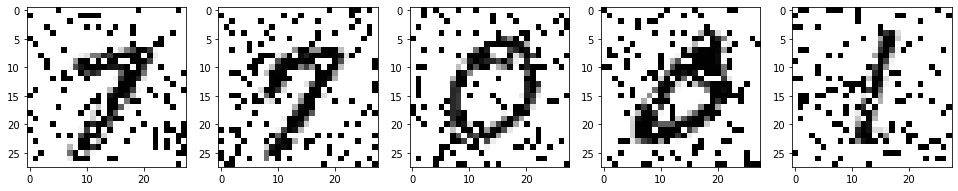

In [16]:
# Viewing sample before actual run

x = x_train_noise_SnP[0:5]
plt.figure(figsize=(20,3))
for i in range (len(x)):
  ax = plt.subplot(1,6,i+1)
  plt.imshow(x[i].reshape(28,28), cmap = 'gray')

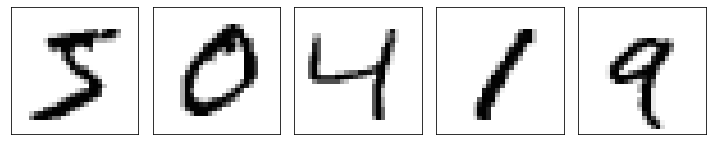

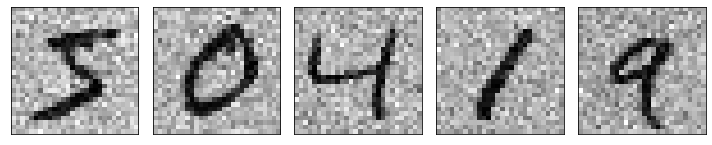

In [17]:
# Viewimg clean data and its noisy counterpart before actual training

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_noisy[i].reshape(28, 28), cmap='gray')
plt.tight_layout()
plt.show()


In [18]:
# Creating the model

model = Sequential()

# Encoding (or Compressing) images
model.add(Conv2D(32,(3,3), activation = 'relu', padding = 'same', input_shape = (28, 28, 1)))
# 32 -> dimentionality of the output space, relu -> activation function, padding is 'same' that results in padding the 
# input such that the output has the same length as the original input
model.add(MaxPooling2D((2,2), padding = 'same'))
# Downscaling by a factor of 2x2
model.add(Conv2D(8,(3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'same'))
model.add(Conv2D(8,(3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'same'))

# Decoding (or Decompressing) images
model.add(Conv2D(8,(3,3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(8,(3,3), activation = 'relu', padding = 'same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32,(3,3), activation = 'relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1,(3,3), activation = 'relu', padding = 'same'))


model.compile(optimizer='adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         2312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 8)           5

In [0]:
# Using early stopping 

from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [20]:
# Training the model with epoch size 100 and batch size 128
 
model.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise_G, x_test),
                callbacks=[early_stopper])

Epoch 1/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1572 - val_loss: 0.0671
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0572 - val_loss: 0.0444
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0473 - val_loss: 0.0379
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0430 - val_loss: 0.0345
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0406 - val_loss: 0.0322
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0387 - val_loss: 0.0315
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0374 - val_loss: 0.0296
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0362 - val_loss: 0.0282
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0350 - val_loss: 0.0269
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0340 - val_lo

In [21]:
# Saving the weights

model.save('DenoisingAutoencoder.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: DenoisingAutoencoder.model/assets


In [0]:
# Predicting the reconstructed denoised images of Poisson noise images
x_pred_P = model.predict(x_test_noise_P)

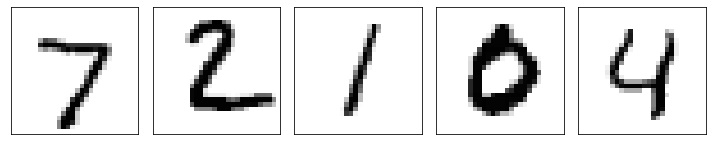

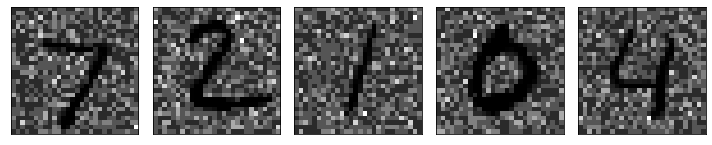

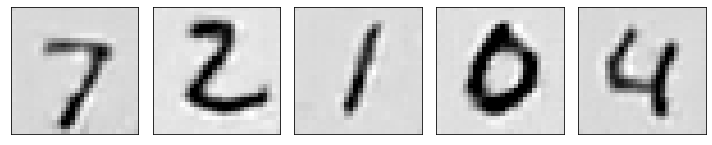

<Figure size 432x288 with 0 Axes>

In [24]:
# Poisson Noise reconstruction from Autoencoder

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test_noise_P[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()

# to visualize reconstructed images(output of autoencoder)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    #plt.title('Predicted Images by Autoencoder', fontsize=10)
    plt.imshow(x_pred_P[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()
plt.savefig("Denoising Autoencoder + Poisson Noise", bbox_inches='tight', format = 'png')

In [25]:
# Calculating average SSIM and PSNR for 10000 samples of Poisson noised images 

ssim_aeP_mnist = 0
ssim_aeP_mnist_list =[]
psnr_aeP_mnist_list = []
                       

for i in range (len(x_test)):
    ssim_aeP_mnist = measure.compare_ssim(x_pred_P[i], x_test[i],multichannel = True, win_size = None)
    ssim_aeP_mnist_list.append(ssim_aeP_mnist)
    psnr_aeP_mnist = measure.compare_psnr(x_test[i], x_pred_P[i])
    psnr_aeP_mnist_list.append(psnr_aeP_mnist)

print('Average SSIM of clean test images vs predicted denoised images') 
print(np.sum(ssim_aeP_mnist_list)/len(ssim_aeP_mnist_list))
print('Average PSNR of predicted denoised images') 
print(np.sum(psnr_aeP_mnist_list)/len(psnr_aeP_mnist_list))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


Average SSIM of clean test images vs predicted denoised images
0.8617972373802253
Average PSNR of predicted denoised images
18.65735090877798


In [0]:
#Predicting reconstructed denoised images of Gaussian noise images

x_pred_G = model.predict(x_test_noise_G)

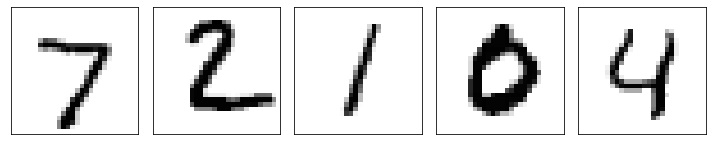

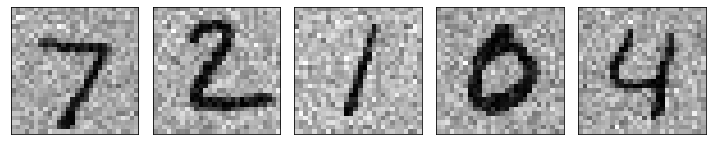

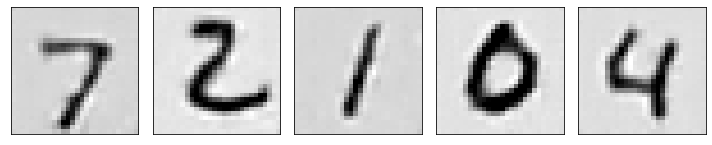

<Figure size 432x288 with 0 Axes>

In [27]:
# Gaussian Noise reconstruction from Autoencoder

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test_noise_G[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()

# to visualize reconstructed images(output of autoencoder)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_pred_G[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()
plt.savefig("Denoising Autoencoder + Gaussian Noise", bbox_inches='tight', format = 'png')

In [28]:
# Calculating average SSIM and PSNR for 10000 samples of Gaussian noised images 


ssim_aeG_mnist = 0
ssim_aeG_mnist_list =[]
psnr_aeG_mnist_list = []
                       

for i in range (len(x_test)):
    ssim_aeG_mnist = measure.compare_ssim(x_pred_G[i], x_test[i],multichannel = True, win_size = None)
    ssim_aeG_mnist_list.append(ssim_aeG_mnist)
    psnr_aeG_mnist = measure.compare_psnr(x_test[i], x_pred_G[i])
    psnr_aeG_mnist_list.append(psnr_aeG_mnist)

print('Average SSIM of clean test images vs predicted denoised images') 
print(np.sum(ssim_aeG_mnist_list)/len(ssim_aeG_mnist_list))
print('Average PSNR of predicted denoised images') 
print(np.sum(psnr_aeG_mnist_list)/len(psnr_aeG_mnist_list))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # This is added back by InteractiveShellApp.init_path()


Average SSIM of clean test images vs predicted denoised images
0.8630922519160813
Average PSNR of predicted denoised images
18.62476046800183


In [0]:
#Predicting reconstructed denoised images of Salt and Pepper noise images

x_pred_SnP = model.predict(x_test_noise_SnP)

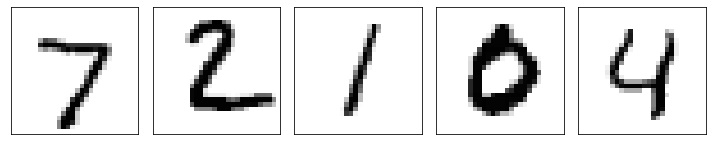

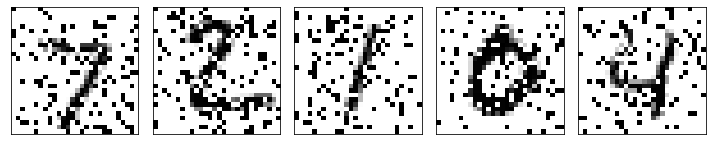

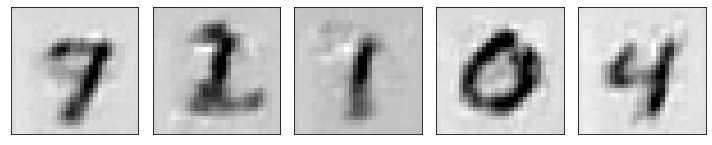

<Figure size 432x288 with 0 Axes>

In [30]:
# Salt and Pepper Noise reconstruction from Autoencoder

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_test_noise_SnP[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()

# to visualize reconstructed images(output of autoencoder)
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([]) # to remove x-axis  the [] empty list indicates this
    plt.yticks([]) # to remove y-axis
    plt.grid(False) # to remove grid
    plt.imshow(x_pred_SnP[i].reshape(28, 28), cmap='gray') #display the image 
plt.tight_layout() # to have a proper space in the subplots
plt.show()
plt.savefig("Denoising Autoencoder + Salt and Pepper Noise", bbox_inches='tight', format = 'png')

In [31]:
# Calculating average SSIM and PSNR for 10000 samples of Salt and Pepper noised images 

ssim_aeSnP_mnist = 0
ssim_aeSnP_mnist_list =[]
psnr_aeSnP_mnist_list = []
                       

for i in range (len(x_test)):
    ssim_aeSnP_mnist = measure.compare_ssim(x_pred_SnP[i], x_test[i],multichannel = True, win_size = None)
    ssim_aeSnP_mnist_list.append(ssim_aeSnP_mnist)
    psnr_aeSnP_mnist = measure.compare_psnr(x_test[i], x_pred_SnP[i])
    psnr_aeSnP_mnist_list.append(psnr_aeSnP_mnist)

print('SSIM of clean test images vs predicted denoised images') 
    
print(np.sum(ssim_aeG_mnist_list)/len(ssim_aeG_mnist_list))
print('PSNR of clean test images vs predicted denoised images') 
print(np.sum(psnr_aeG_mnist_list)/len(psnr_aeG_mnist_list))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


SSIM of clean test images vs predicted denoised images
0.8630922519160813
PSNR of clean test images vs predicted denoised images
18.62476046800183
